# First NN to test a simple model

In this notebook, we implement a simple neural network to predict the photovoltaic power generation. We use the data from the University of Liege.

### import libraries

In [32]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [33]:
DATA_PATH = 'data/cleaned.csv'

In [34]:
df = pd.read_csv('data/cleaned.csv', sep=';',  parse_dates=[0])
df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df

,date,id,Power_1,Power_2,Power_3,Power_4,Power_5,Power_6,Power_7,Power_8,...,CU,CM,CD,TT2M,ST,RH2m,WS10m,WS100m,PREC,SNOW
0,2022-01-01 02:15:00+02:00,577035.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,8.38,8.38,93.34,3.46,9.10,0.0,0.0
1,2022-01-01 02:30:00+02:00,577038.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,8.52,8.52,92.18,3.81,9.52,0.0,0.0
2,2022-01-01 02:45:00+02:00,577041.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,8.66,8.66,90.91,4.15,9.66,0.0,0.0
3,2022-01-01 03:00:00+02:00,577044.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,8.76,8.76,90.18,4.36,9.50,0.0,0.0
4,2022-01-01 03:15:00+02:00,577047.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,8.74,8.74,90.39,4.38,9.16,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28845,2022-12-31 21:30:00+02:00,667201.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.76,0.0,0.0,13.14,13.14,72.48,7.39,13.79,0.0,0.0
28846,2022-12-31 21:45:00+02:00,667204.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.0,0.0,13.13,13.13,72.07,7.46,13.93,0.0,0.0
28847,2022-12-31 22:00:00+02:00,667207.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.0,0.0,13.12,13.12,71.67,7.52,14.04,0.0,0.0
28848,2022-12-31 22:15:00+02:00,667210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.0,0.0,13.10,13.10,71.36,7.55,14.10,0.0,0.0


In [35]:
col_to_keep = ['Power_Total','date' ,'SWD', 'SWDtop', 'CU', 'CM', 'CD', 'TT2M', 'ST', 'RH2m', 'WS10m', 'WS100m', 'PREC', 'SNOW']
df = df.loc[:,col_to_keep]
df.dropna(inplace=True)
df.head()

,Power_Total,date,SWD,SWDtop,CU,CM,CD,TT2M,ST,RH2m,WS10m,WS100m,PREC,SNOW
0,0.0,2022-01-01 02:15:00+02:00,0.0,0.0,0.0,0.0,0.0,8.38,8.38,93.34,3.46,9.10,0.0,0.0
1,0.0,2022-01-01 02:30:00+02:00,0.0,0.0,0.0,0.0,0.0,8.52,8.52,92.18,3.81,9.52,0.0,0.0
2,0.0,2022-01-01 02:45:00+02:00,0.0,0.0,0.0,0.0,0.0,8.66,8.66,90.91,4.15,9.66,0.0,0.0
3,0.0,2022-01-01 03:00:00+02:00,0.0,0.0,0.0,0.0,0.0,8.76,8.76,90.18,4.36,9.50,0.0,0.0
4,0.0,2022-01-01 03:15:00+02:00,0.0,0.0,0.0,0.0,0.0,8.74,8.74,90.39,4.38,9.16,0.0,0.0


In [36]:
#split the column date into month, day, hour, minutes
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['hour'] = df['date'].apply(lambda x: x.hour)
df['minutes'] = df['date'].apply(lambda x: x.minute)
df.drop(columns=['date'], inplace=True)
df.head()

,Power_Total,SWD,SWDtop,CU,CM,CD,TT2M,ST,RH2m,WS10m,WS100m,PREC,SNOW,month,day,hour,minutes
0,0.0,0.0,0.0,0.0,0.0,0.0,8.38,8.38,93.34,3.46,9.10,0.0,0.0,1,1,2,15
1,0.0,0.0,0.0,0.0,0.0,0.0,8.52,8.52,92.18,3.81,9.52,0.0,0.0,1,1,2,30
2,0.0,0.0,0.0,0.0,0.0,0.0,8.66,8.66,90.91,4.15,9.66,0.0,0.0,1,1,2,45
3,0.0,0.0,0.0,0.0,0.0,0.0,8.76,8.76,90.18,4.36,9.50,0.0,0.0,1,1,3,0
4,0.0,0.0,0.0,0.0,0.0,0.0,8.74,8.74,90.39,4.38,9.16,0.0,0.0,1,1,3,15


In [37]:
class TriplePs(Dataset):
    def __init__(self, data, test = False, test_size = 0.2, seed=42):
        self.data = data
        self.nb_input = len (data.columns) - 1
        self.input = data.iloc[:, 1:]
        self.output = data.iloc[:, 0]
        self.test = test
        self.train_size = 1-test_size

        self.seed = seed
        np.random.seed(seed)

        self.idx = np.arange(len(data))
        np.random.shuffle(self.idx)
        self.train_idx = self.idx[:int(len(self.idx)*self.train_size)]
        self.test_idx = self.idx[int(len(self.idx)*self.train_size):]

        #convert to tensor
        self.input = torch.tensor(self.input.values, dtype=torch.float32)
        self.output = torch.tensor(self.output.values, dtype=torch.float32)

        if self.test:
            self.input = self.input[self.test_idx]
            self.output = self.output[self.test_idx]
        else:
            self.input = self.input[self.train_idx]
            self.output = self.output[self.train_idx]


    def __len__(self):
        return len(self.input)
    
    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]
    


In [38]:
trainset = TriplePs(df)
testset = TriplePs(df, test=True)

In [39]:
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [40]:
next(iter(trainloader))

[tensor([[ 7.8000e-01,  3.6720e+01,  0.0000e+00,  0.0000e+00,  1.0000e+00,
           1.4300e+00,  1.4300e+00,  9.9200e+01,  2.3100e+00,  3.9400e+00,
           1.0000e-02,  0.0000e+00,  1.1000e+01,  1.9000e+01,  1.8000e+01,
           3.0000e+01],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00,  3.9000e-01,
           4.6700e+00,  4.6700e+00,  9.1300e+01,  6.1800e+00,  1.2120e+01,
           2.0000e-02,  0.0000e+00,  1.2000e+01,  1.9000e+01,  7.0000e+00,
           1.5000e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          -2.6600e+00, -2.6600e+00,  9.9420e+01,  1.1700e+00,  2.5800e+00,
           1.0000e-02,  7.2300e+00,  1.2000e+01,  1.0000e+01,  8.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  7.0000e-02,
           1.5740e+01,  1.5740e+01,  5.4530e+01,  2.0000e+00,  4.6700e+00,
           0.0000e+00,  0.0000e+00,  6.0000e+00,  1.2000e+01,  3.0000e+00,
           0.0000e+00]]),
 t

### Neural Network to predict the photovoltaic power generation using simple regression

In [59]:
class Net(nn.Module):
    def __init__(self, len):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(len, 12)
        self.fc2 = nn.Linear(12, 24)
        self.fc3 = nn.Linear(24, 1)

        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [60]:
net = Net(len(trainset.input[0]))
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
nb_epoch = 15
losses = []


In [61]:
for epoch in range(nb_epoch):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = torch.tensor(inputs, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000}')
            losses.append(running_loss)
            running_loss = 0.0


/tmp/ipykernel_96042/4185963409.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/tmp/ipykernel_96042/4185963409.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)


[1, 2000] loss: 10901856818.551468
[1, 4000] loss: 9476635137.568
[2, 2000] loss: 9666483078.56
[2, 4000] loss: 9358419108.0
[3, 2000] loss: 9582243847.2
[3, 4000] loss: 8961468359.328
[4, 2000] loss: 9303072194.688
[4, 4000] loss: 9444564051.104
[5, 2000] loss: 9421149978.24
[5, 4000] loss: 9325306615.328
[6, 2000] loss: 8931776781.952
[6, 4000] loss: 9426349525.536
[7, 2000] loss: 9476767382.528
[7, 4000] loss: 9218713426.4
[8, 2000] loss: 9182180540.064
[8, 4000] loss: 9477534933.856
[9, 2000] loss: 9350387011.904
[9, 4000] loss: 9485530614.496
[10, 2000] loss: 9642103809.024
[10, 4000] loss: 9501045280.928
[11, 2000] loss: 9784274098.048
[11, 4000] loss: 9106705810.064
[12, 2000] loss: 9152077329.536
[12, 4000] loss: 9321267075.456
[13, 2000] loss: 9313875051.92
[13, 4000] loss: 9519362845.664
[14, 2000] loss: 9112754458.96
[14, 4000] loss: 9571721844.48
[15, 2000] loss: 9205037318.976
[15, 4000] loss: 9661094948.224


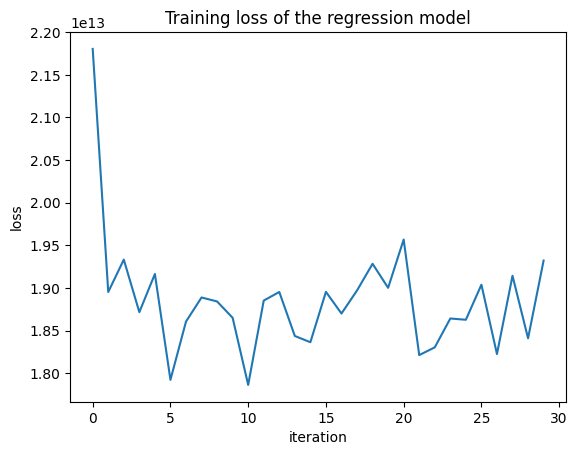

In [62]:
# plot the losses
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Training loss of the regression model')
plt.show()

### Neural Network to predict the photovoltaic power generation with a normal distribution

In [65]:
class Net_Normal(nn.Module):
    def __init__(self, len):
        super(Net_Normal, self).__init__()  # Corrected here
        self.fc1 = nn.Linear(len, 12)
        self.fc2 = nn.Linear(12, 24)
        self.fc3 = nn.Linear(24, 2)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        mu, logvar = torch.chunk(x, 2, dim=1)
        return self.reparametrize(mu, logvar), mu, logvar


In [66]:

net = Net_Normal(len(trainset.input[0]))
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
nb_epoch = 15
losses = []


In [67]:
for epoch in range(nb_epoch):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = torch.tensor(inputs, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)
        
        optimizer.zero_grad()
        outputs, mu, logvar = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000}')
            losses.append(running_loss)
            running_loss = 0.0


/tmp/ipykernel_96042/2892581068.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/tmp/ipykernel_96042/2892581068.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)


[1, 2000] loss: 13840974065.158293
[1, 4000] loss: 13801365978.54686
[2, 2000] loss: 9948762346.504
[2, 4000] loss: 9231642771.504
[3, 2000] loss: 9790475082.432
[3, 4000] loss: 9129775883.424
[4, 2000] loss: 9213968229.328
[4, 4000] loss: 9591584515.456
[5, 2000] loss: 9880212429.472
[5, 4000] loss: 8889788891.52
[6, 2000] loss: 9218831116.048
[6, 4000] loss: 9504910352.096
[7, 2000] loss: 9426240580.64
[7, 4000] loss: 9364267465.28
[8, 2000] loss: 9097172794.304
[8, 4000] loss: 9701045165.824
[9, 2000] loss: 9322470588.8
[9, 4000] loss: 9439837117.952
[10, 2000] loss: 9116876044.256
[10, 4000] loss: 9537990360.0
[11, 2000] loss: 9588296291.376
[11, 4000] loss: 9254032479.616
[12, 2000] loss: 9342074587.616
[12, 4000] loss: 9306540837.792
[13, 2000] loss: 9320491414.784
[13, 4000] loss: 9383828871.328
[14, 2000] loss: 9140864287.104
[14, 4000] loss: 9525641731.36
[15, 2000] loss: 9703858483.808
[15, 4000] loss: 9086927586.08
[16, 2000] loss: 9316869053.504


KeyboardInterrupt: 

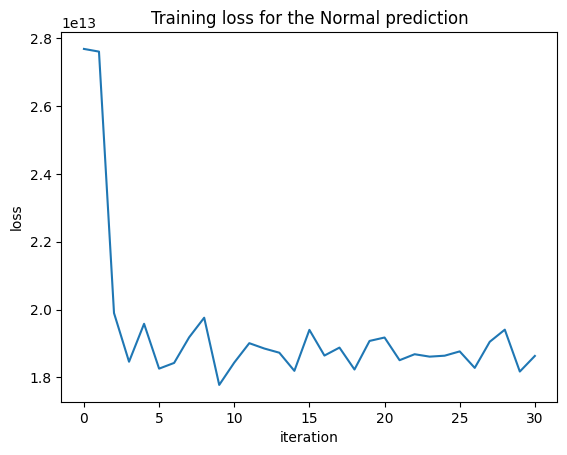

In [68]:
# plot the losses
plt.plot(losses)
plt.title('Training loss for the Normal prediction')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()